In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Libraries
import pandas as pd
import os

from src.data import prep_data as prep
from src.models import model_schemata as schema
from src.models import build_model as build

In [6]:
# os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [7]:
# reading csv from files into dict
data = {}
data['e_ksea'] = pd.read_csv('data/processed/ebdt_data/sub_network_p/e_ksea_penalised.csv')
data['p_fc'] = pd.read_csv('data/processed/ebdt_data/sub_network_p/p_fc.csv')

Scale fold changes to increase N of baseline values

In [8]:
prep.scale_fc_column(data['p_fc'], 'prob')
# set negative values to 0.001
data['p_fc'].loc[data['p_fc']['prob'] < 0.001, 'prob'] = 0.001
data['p_fc']

,phosphosite,sample,value,prob,p_dec,p_inc
0,ABI1(Y213),AZD5438,inc,0.795799,0.001000,0.897593
1,ANXA2P2(Y24),AZD5438,dec,0.729442,0.864315,0.001000
2,ATF1(S198),AZD5438,dec,0.999546,0.999773,0.001000
3,BCLAF1(Y284),AZD5438,inc,0.886673,0.001000,0.943166
4,HIPK2(Y361),AZD5438,dec,0.460094,0.729236,0.001000
...,...,...,...,...,...,...
544,HIPK2(Y361),MK2206,dec,0.171695,0.584604,0.001000
545,PTTG1IP(Y174),MK2206,dec,0.569925,0.784317,0.001000
546,PXN(Y118),MK2206,dec,0.408879,0.703552,0.001000
547,PXN(Y88),MK2206,inc,0.155731,0.001000,0.576598


<Axes: >

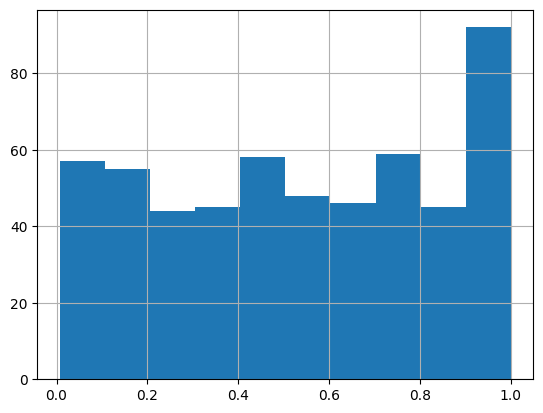

In [9]:
data['p_fc']['prob'].hist()

In [10]:
# Calculate 'p_dec' and 'p_inc' columns based on conditions
data['p_fc']['p_dec'] = data['p_fc'].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
data['p_fc']['p_inc'] = data['p_fc'].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)
data['p_fc']

,phosphosite,sample,value,prob,p_dec,p_inc
0,ABI1(Y213),AZD5438,inc,0.795799,0.001000,0.795799
1,ANXA2P2(Y24),AZD5438,dec,0.729442,0.729442,0.001000
2,ATF1(S198),AZD5438,dec,0.999546,0.999546,0.001000
3,BCLAF1(Y284),AZD5438,inc,0.886673,0.001000,0.886673
4,HIPK2(Y361),AZD5438,dec,0.460094,0.460094,0.001000
...,...,...,...,...,...,...
544,HIPK2(Y361),MK2206,dec,0.171695,0.171695,0.001000
545,PTTG1IP(Y174),MK2206,dec,0.569925,0.569925,0.001000
546,PXN(Y118),MK2206,dec,0.408879,0.408879,0.001000
547,PXN(Y88),MK2206,inc,0.155731,0.001000,0.155731


In [12]:
e_ksea_ad = prep.expand_ad_cpd(data['e_ksea'], 'value')
p_fc_ad = prep.expand_ad_cpd(data['p_fc'], 'value')
p_fc_ad

,phosphosite,sample,value,prob,p_dec,p_inc,p_base
0,ABI1(Y213),AC220,dec,0.319606,0.319606,0.001000,0.679394
1,ABI1(Y213),AC220,inc,0.319606,0.001000,0.319606,0.679394
2,ABI1(Y213),AT13148,dec,0.048178,0.048178,0.001000,0.950822
3,ABI1(Y213),AT13148,inc,0.048178,0.001000,0.048178,0.950822
4,ABI1(Y213),AZ20,dec,0.014759,0.014759,0.001000,0.984241
...,...,...,...,...,...,...,...
1093,RBM39(Y95),U73122,inc,0.370123,0.001000,0.370123,0.628877
1094,RBM39(Y95),Ulixertinib,dec,0.882625,0.882625,0.001000,0.116375
1095,RBM39(Y95),Ulixertinib,inc,0.882625,0.001000,0.882625,0.116375
1096,RBM39(Y95),Vemurafenib,dec,0.292335,0.292335,0.001000,0.706665


In [13]:
# Mapping data to Problog predicates
# make sure to delete 'base' from schemata and AnnotatedDisjunctionClauseTemplate
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(e_ksea_ad, 'enzyme', 'sample', 'value')
predicates['e_ksea'].add_ad_probabilities(e_ksea_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(p_fc_ad, 'phosphosite', 'sample', 'value')
predicates['p_fc'].add_ad_probabilities(p_fc_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')

In [14]:
model_lfi = 'models/ebdt_data/sub_network/p_model/p_model_lfi_exp11.pl'
for predicate in predicates: 
    ad_generator = build.ProblogStatementGenerator(predicates[predicate])
    clauses = ad_generator.generate_ad_clauses(type='boolean')
    clauses.extend(ad_generator.generate_ad_clauses(type='domain'))
    build.insert_statements(model=model_lfi, statements=clauses, location='%% p1::{}'.format(predicate)) # insert into Problog file

In [15]:
data['p_fc'].to_csv('data/processed/ebdt_data/sub_network_p/p_fc_scaled.csv', index=False)